<a href="https://colab.research.google.com/github/m4dhv/terafac/blob/main/level_1_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Option 1: CIFAR-10 Image Classification**


##**Level 1 : Baseline Model**

In [ ]:
from torchvision import datasets
datasets.CIFAR10(root='./data', download=True)

100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
#importing dependencies
#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

from matplotlib import pyplot as plt
import numpy as np

#torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision import models

from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


PyTorch version: 2.9.0+cu126
CUDA available: True
GPU Name: Tesla T4


In [ ]:
BATCH_SIZE = 128
NUM_WORKERS = 2

# CIFAR-10 normalization values
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # ResNet expects bigger images
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

classes = train_dataset.classes
print("Classes:", classes)


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze backbone layers (faster + stable baseline)
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for CIFAR-10 (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)

model = model.to(device)
print(model.fc)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


Linear(in_features=2048, out_features=10, bias=True)


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)  # train only final layer

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = 100.0 * correct / total
    return avg_loss, acc


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Evaluating", leave=False):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)

        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = 100.0 * correct / total
    return avg_loss, acc


In [ ]:
EPOCHS = 10

train_losses, train_accs = [], []
test_losses, test_accs = [], []

best_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss, test_acc   = evaluate(model, test_loader, criterion)

    scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print("Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print("Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2f}%")

    # Saving the best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "best_resnet50_cifar10.pth")
        print("Best model saved")

print("\nBest Test Accuracy:", best_acc)



Epoch 1/10


Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%
Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2f}%
Best model saved

Epoch 2/10


Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%
Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2f}%
Best model saved

Epoch 3/10


Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%
Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2f}%

Epoch 4/10


Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%
Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2f}%
Best model saved

Epoch 5/10


Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%
Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2f}%
Best model saved

Epoch 6/10


Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%
Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2f}%
Best model saved

Epoch 7/10


Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%
Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2f}%
Best model saved

Epoch 8/10


Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%
Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2f}%

Epoch 9/10


Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%
Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2f}%
Best model saved

Epoch 10/10


Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%
Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2f}%
Best model saved

Best Test Accuracy: 85.45


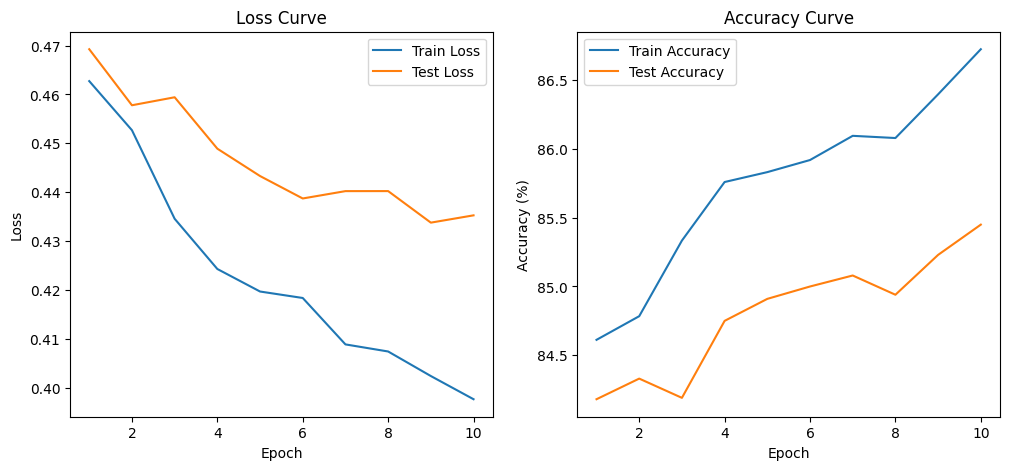

In [ ]:
epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, test_accs, label="Test Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()
